In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

In [17]:


# Load the dataset (replace with the actual path to your dataset)
data = pd.read_csv("heart_disease.csv")

# Separate numerical and categorical columns
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Handle missing values for numerical columns
numerical_imputer = SimpleImputer(strategy='median')
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])
joblib.dump(numerical_imputer, "numerical_imputer.pkl")

# Handle missing values for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])
joblib.dump(categorical_imputer, "categorical_imputer.pkl")

# Encode binary categorical variables
label_encoders = {}
for col in ['Sex', 'ExerciseAngina', 'ST_Slope']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
joblib.dump(label_encoders, "label_encoders.pkl")

# One-hot encode multi-class categorical variables
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
one_hot_encoded = one_hot_encoder.fit_transform(data[['ChestPainType', 'RestingECG']])
joblib.dump(one_hot_encoder, "one_hot_encoder.pkl")

# Add one-hot encoded columns back to the dataset
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(['ChestPainType', 'RestingECG']))
data = pd.concat([data.drop(['ChestPainType', 'RestingECG'], axis=1), one_hot_encoded_df], axis=1)

# Standardize numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
joblib.dump(scaler, "scaler.pkl")

# Apply PCA for dimensionality reduction
data_features = data.drop('HeartDisease', axis=1)  # Exclude target column
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data_features)
joblib.dump(pca, "pca.pkl")

print("All preprocessing models have been saved.")


All preprocessing models have been saved.


In [18]:
# Load preprocessed dataset
data = pd.read_csv("preprocessed_heart_disease.csv")

# Load preprocessing models
numerical_imputer = joblib.load("numerical_imputer.pkl")
categorical_imputer = joblib.load("categorical_imputer.pkl")
label_encoders = joblib.load("label_encoders.pkl")
one_hot_encoder = joblib.load("one_hot_encoder.pkl")
scaler = joblib.load("scaler.pkl")
pca = joblib.load("pca.pkl")

# Feature-target split
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

# Feature scaling
X_scaled = scaler.fit_transform(X)

In [19]:
# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    # 'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Hyperparameter grids
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

In [20]:
# 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models
best_estimators = {}
auc_scores = {}

for model_name, model in models.items():
    print(f"Optimizing {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=skf, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_scaled, y)
    best_estimators[model_name] = grid_search.best_estimator_
    auc_scores[model_name] = grid_search.best_score_

    # Save optimized model
    joblib.dump(grid_search.best_estimator_, f"{model_name.replace(' ', '_').lower()}_optimized_model.pkl")

# Identify the best model
best_model_name = max(auc_scores, key=auc_scores.get)
best_model = best_estimators[best_model_name]
print(f"Best Model: {best_model_name} with AUC = {auc_scores[best_model_name]:.4f}")
joblib.dump(best_model, "best_heart_disease_model.pkl")

# Load the best model
best_model = joblib.load("best_heart_disease_model.pkl")



Optimizing Logistic Regression...
Optimizing Random Forest...
Optimizing SVM...
Optimizing KNN...
Optimizing Gradient Boosting...
Best Model: Gradient Boosting with AUC = 0.9285


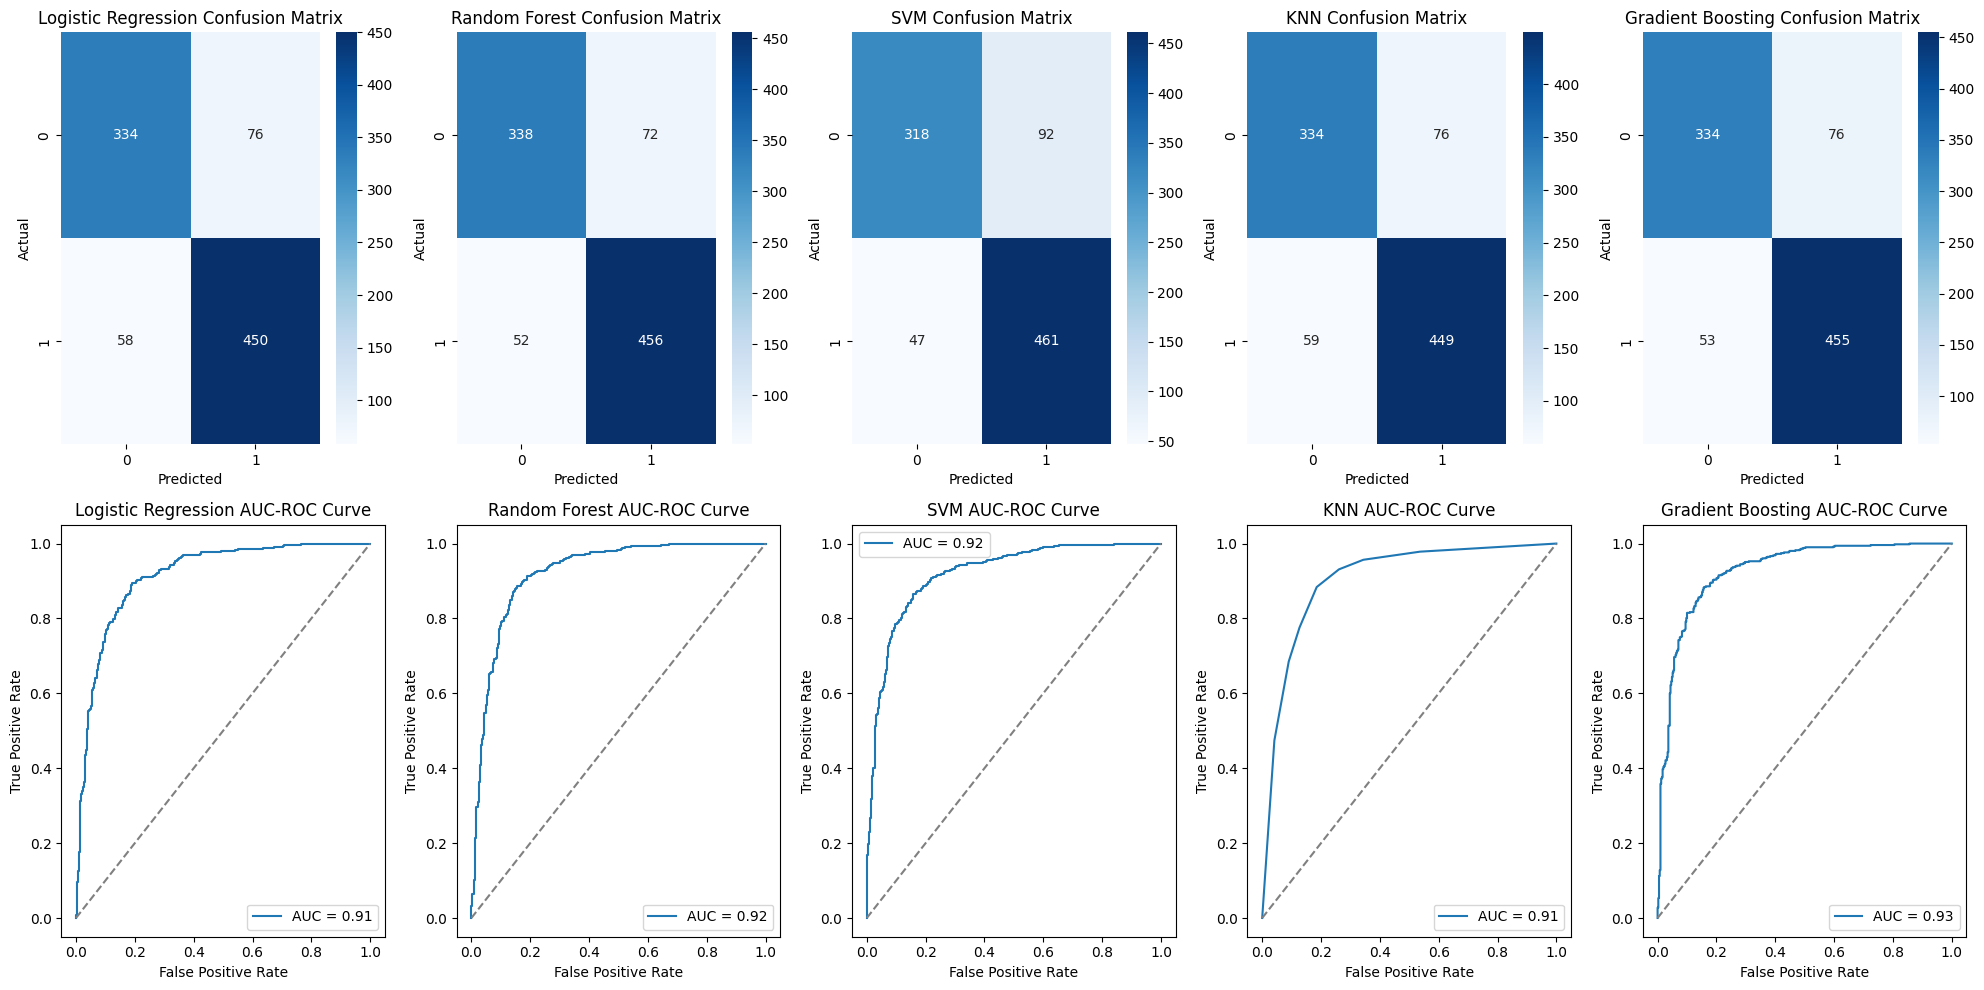

Logistic Regression AUC: 0.9159
Random Forest AUC: 0.9241
SVM AUC: 0.9207
KNN AUC: 0.9062
Gradient Boosting AUC: 0.9285


In [21]:
# Plot confusion matrices and AUC-ROC curves
plt.figure(figsize=(20, 10))

for i, (model_name, model) in enumerate(best_estimators.items()):
    y_pred = cross_val_predict(model, X_scaled, y, cv=skf, method='predict')
    y_pred_proba = cross_val_predict(model, X_scaled, y, cv=skf, method='predict_proba')[:, 1]
    cm = confusion_matrix(y, y_pred)

    # Confusion matrix
    plt.subplot(2, len(best_estimators), i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # AUC-ROC curve
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.subplot(2, len(best_estimators), len(best_estimators) + i + 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'{model_name} AUC-ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

plt.tight_layout()
plt.show()

# Display AUC scores
for model_name, score in auc_scores.items():
    print(f"{model_name} AUC: {score:.4f}")
